# **Pendulum-v0**

**Video link for explaination(Please use Chrome)** :- https://iiitaphyd-my.sharepoint.com/:v:/g/personal/samanvaya_panda_research_iiit_ac_in/EelZMEPseGtJoDeHzxXac_UBnpiwU0AvEpN650gvMPPEKg?e=aa4e2g

This notebook consists of implementations of various agents for Pendulum enviroment of OpenAi Gym. Pendulum enviroment has an continuous action space(-2 to 2).


In [3]:
import gym
import numpy as np
import tensorflow as tf
from tensorflow.keras import Sequential, layers
from matplotlib import pyplot as plt
import keras.backend as K

**Defining our enviroment**

In [4]:
ENV="Pendulum-v0"
episodes=200

env=gym.make(ENV) 

## **Vanilla Policy Gradient Agent**

A vanilla policy gradient agent perform default policy gradient updates to learn a policy.

In [ ]:
class VanillaPolicyAgent:
  def __init__(self, env):

    self.env=env
    self.state_shape=env.observation_space.shape
    self.action_shape=env.action_space.shape[0]
    self.gamma=0.99 
    self.alpha=1e-4 
    self.learning_rate=0.01 
    self.epsilon = 0.1
    self.model=self.create_model() 
    
    self.states=[]
    self.gradients=[] 
    self.rewards=[]
    self.probs=[]
    self.policy_var=[]
    self.total_rewards=[]
  
  def create_model(self):

    model=Sequential()
    model.add(layers.Dense(24, input_shape=self.state_shape, activation="relu"))
    model.add(layers.Dense(12, activation="relu"))
    model.add(layers.Dense(self.action_shape)) 
    model.compile(loss="mse",
            optimizer=tf.keras.optimizers.Adam(lr=self.learning_rate))
        
    return model
  
  def set_parametes(self, state, action, action_prob, reward):

    self.gradients.append(action-action_prob)
    self.states.append(state)
    self.rewards.append(reward)
    self.probs.append(action_prob)

  def get_action(self, state):

    state=state.reshape([1, state.shape[0]])
    possible_action=self.model.predict(state).flatten()
    if np.random.random() > self.epsilon:
      return possible_action, np.array([1-self.epsilon])
    else:
      return np.array([4*np.random.random()-2]), np.array([self.epsilon])

  def get_discounted_rewards(self, rewards): 
    
    discounted_rewards=[]
    cumulative_total_return=0
    for reward in rewards[::-1]:      
      cumulative_total_return=(cumulative_total_return*self.gamma)+reward
      discounted_rewards.insert(0, cumulative_total_return)

    mean_rewards=np.mean(discounted_rewards)
    std_rewards=np.std(discounted_rewards)
    norm_discounted_rewards=(discounted_rewards-
                          mean_rewards)/(std_rewards+1e-5)
    
    return norm_discounted_rewards
  
  def update_policy(self):

    states = np.reshape(self.states, (len(self.states), len(self.states[0])))
    gradients=np.reshape(self.gradients, (len(self.gradients), len(self.gradients[0])))
    rewards=np.reshape(self.rewards, (len(self.rewards), 1))

    discounted_rewards=self.get_discounted_rewards(rewards)
    self.policy_var.append(np.var(discounted_rewards))
 
    gradients*=discounted_rewards
    gradients=self.alpha*np.vstack([gradients])+self.probs

    self.model.train_on_batch(states, gradients)
    
    self.states, self.probs, self.gradients, self.rewards=[], [], [], []

  def train(self, episodes):
    
    env=self.env
    total_rewards=np.zeros(episodes)

    for episode in range(episodes):
      state=env.reset()
      done=False          
      episode_reward=0 
      
      while not done:
        action, prob=self.get_action(state)
        next_state, reward, done, _=env.step(action)
        self.set_parametes(state, action, prob, reward)
        state=next_state
        episode_reward+=reward

        if done:
          self.update_policy()

      total_rewards[episode]=episode_reward
      if episode%5 == 0:
        print("For", episode, ": Reward =", episode_reward)
    self.total_rewards=total_rewards

  

**Training our Agent**

In [ ]:
vanilla_agent = VanillaPolicyAgent(env)
vanilla_agent.train(episodes)

For 0 : Reward = -1830.221844977152
For 5 : Reward = -1338.968227500541
For 10 : Reward = -1545.7804820432711
For 15 : Reward = -1307.253230977157
For 20 : Reward = -1411.1160240761637
For 25 : Reward = -1536.2129115117614
For 30 : Reward = -1594.9643347565518
For 35 : Reward = -1326.5391077250931
For 40 : Reward = -1303.1473087787049
For 50 : Reward = -1292.5286335281435
For 55 : Reward = -1177.9165336631277
For 60 : Reward = -1333.3837986864326
For 65 : Reward = -1595.789926431901
For 70 : Reward = -1477.7600216804412
For 75 : Reward = -949.0115573524855
For 80 : Reward = -1461.2452625242831
For 85 : Reward = -1634.4626224505273
For 90 : Reward = -1290.5141177433163
For 95 : Reward = -1317.9179247816792
For 100 : Reward = -1061.4283833704085
For 105 : Reward = -1029.7011054408156
For 110 : Reward = -1648.533790144102
For 115 : Reward = -1168.0111953799278
For 120 : Reward = -1049.544676615274
For 125 : Reward = -1024.7710728783518
For 130 : Reward = -953.3162682904729
For 135 : Rewar

**Plotting Results**

The following plot shows rewards obtained in each episode by the agent.

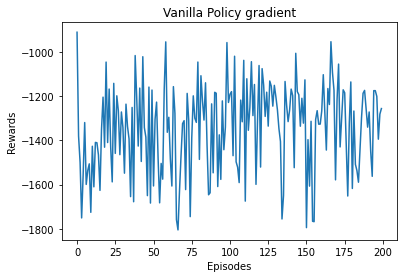

In [ ]:
plt.plot(vanilla_agent.total_rewards)
plt.title("Vanilla Policy gradient")
plt.xlabel("Episodes")
plt.ylabel("Rewards")
plt.show()

From the above plot we obeserve that the vanilla policy gradient agent doesn't perform well in the continuos enviroment.

## **Policy Gradient with Baseline Agent**

The policy gradient with baseline agent uses a predefined baseline function. A baseline function is used to reduce the variance in gradient computation. We use the value function approximation of an agent as the baseline function. Value function approximation is considered a good baseline function because it gives an future estimate of the state value.

In [ ]:
class BaselineAgent:
  def __init__(self, env):

    self.env=env
    self.state_shape=env.observation_space.shape
    self.action_shape=env.action_space.shape[0]
    self.gamma=0.99 
    self.alpha=1e-4 
    self.learning_rate=0.01 
    self.epsilon = 0.1
    self.model=self.create_model() 
    
    self.states=[]
    self.gradients=[] 
    self.rewards=[]
    self.probs=[]
    self.policy_var=[]
    self.total_rewards=[]
  
  def create_model(self):

    model=Sequential()
    model.add(layers.Dense(24, input_shape=self.state_shape, activation="relu"))
    model.add(layers.Dense(12, activation="relu"))
    model.add(layers.Dense(self.action_shape)) 
    model.compile(loss="mse",
            optimizer=tf.keras.optimizers.Adam(lr=self.learning_rate))
        
    return model
  
  def set_parametes(self, state, action, action_prob, reward):

    self.gradients.append(action-action_prob)
    self.states.append(state)
    self.rewards.append(reward)
    self.probs.append(action_prob)

  def get_action(self, state):

    state=state.reshape([1, state.shape[0]])
    possible_action=self.model.predict(state).flatten()
    if np.random.random() > self.epsilon:
      return possible_action, np.array([1-self.epsilon])
    else:
      return np.array([4*np.random.random()-2]), np.array([self.epsilon])

  def get_discounted_rewards(self, rewards): 
    
    discounted_rewards=[]
    cumulative_total_return=0
    for reward in rewards[::-1]:      
      cumulative_total_return=(cumulative_total_return*self.gamma)+reward
      #Baseline
      cumulative_total_return*=(1-self.epsilon)
      discounted_rewards.insert(0, cumulative_total_return)

    mean_rewards=np.mean(discounted_rewards)
    std_rewards=np.std(discounted_rewards)
    norm_discounted_rewards=(discounted_rewards-
                          mean_rewards)/(std_rewards+1e-5)
    
    return norm_discounted_rewards
  
  def update_policy(self):

    states = np.reshape(self.states, (len(self.states), len(self.states[0])))
    gradients=np.reshape(self.gradients, (len(self.gradients), len(self.gradients[0])))
    rewards=np.reshape(self.rewards, (len(self.rewards), 1))

    discounted_rewards=self.get_discounted_rewards(rewards)
    self.policy_var.append(np.var(discounted_rewards))
 
    gradients*=discounted_rewards
    gradients=self.alpha*np.vstack([gradients])+self.probs

    history=self.model.train_on_batch(states, gradients)
    
    self.states, self.probs, self.gradients, self.rewards=[], [], [], []

    return history

  def train(self, episodes, rollout_n=1, render_n=50):
    
    env=self.env
    total_rewards=np.zeros(episodes)

    for episode in range(episodes):
      state=env.reset()
      done=False          
      episode_reward=0 
      
      while not done:
        action, prob=self.get_action(state)
        next_state, reward, done, _=env.step(action)
        self.set_parametes(state, action, prob, reward)
        state=next_state
        episode_reward+=reward

        if done:
          if episode%rollout_n==0:
            history=self.update_policy()

      total_rewards[episode]=episode_reward
      if episode%5 == 0:
        print("For", episode, ": Reward =", episode_reward)
    self.total_rewards=total_rewards

  

**Traning our agent**

In [ ]:
baseline_agent = BaselineAgent(env)
baseline_agent.train(episodes)

For 0 : Reward = -1705.588073149638
For 5 : Reward = -1455.074229789688
For 10 : Reward = -1461.764409156008
For 15 : Reward = -1630.617747849997
For 20 : Reward = -1206.1001880094714
For 25 : Reward = -1530.5696559243013
For 30 : Reward = -1653.7657231654375
For 35 : Reward = -1744.3921840056778
For 40 : Reward = -1312.8855537644315
For 45 : Reward = -1642.1929252125108
For 50 : Reward = -1201.3986636995405
For 55 : Reward = -1180.7734598092713
For 60 : Reward = -1722.7776618634887
For 65 : Reward = -1597.7253478899752
For 70 : Reward = -1518.288252155732
For 75 : Reward = -1474.3360279416572
For 80 : Reward = -1272.773052137676
For 85 : Reward = -1221.6682741289858
For 90 : Reward = -1120.0654493230757
For 95 : Reward = -1480.5455333675682
For 100 : Reward = -1729.8150414060578
For 105 : Reward = -1175.7992850823675
For 110 : Reward = -1277.993731304853
For 115 : Reward = -1205.403898488811
For 120 : Reward = -1364.1116726076918
For 125 : Reward = -1325.6076300692896
For 130 : Reward

**Plotting Results**

The following plot shows rewards obtained in each episode by the agent.

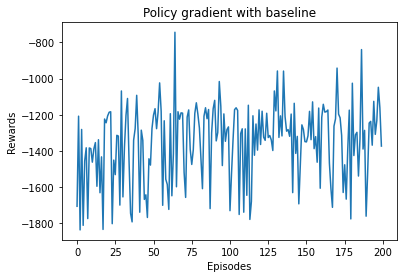

In [ ]:
plt.plot(baseline_agent.total_rewards)
plt.title("Policy gradient with baseline")
plt.xlabel("Episodes")
plt.ylabel("Rewards")
plt.show()

From the above plot we obeserve that the policy gradient with baseline agent doesn't perform well in the continuos enviroment.

**Comparision between variance of Vanilla policy gradient and policy gradient with baseline**

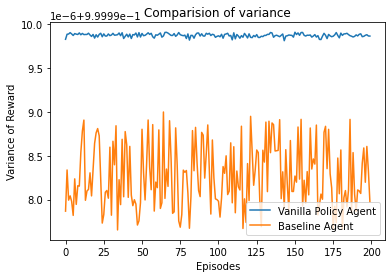

In [ ]:
plt.plot(vanilla_agent.policy_var, label="Vanilla Policy Agent")
plt.plot(baseline_agent.policy_var, label="Baseline Agent")
plt.title("Comparision of variance")
plt.xlabel("Episodes")
plt.ylabel("Variance of Reward")
plt.legend()
plt.show()

From the above plot we observe that policy gradient with baseline agent receives rewards that have less variance compared to a vanilla policy gradient agent. Hence, our baseline is able to reduce variance as it was expected to do so.

## **Actor-Critic Agent**

The actor-critic method uses an additional network for function approximation compared to previous to methods. 

In [ ]:
class ActorCriticAgent:
  def __init__(self, env):
    self.env = env
    self.num_states = env.observation_space.shape[0]
    self.num_actions = env.action_space.shape[0]
    self.gamma = 0.99
    self.tau = 0.005

    self.max_states = 100000
    self.states = np.zeros((self.max_states, self.num_states))
    self.actions = np.zeros((self.max_states, self.num_actions))
    self.reward = np.zeros((self.max_states, 1))
    self.next_state = np.zeros((self.max_states, self.num_states))
    self.total_rewards = []
    self.counter = 0

    self.actor_model = self.create_actor_model()
    self.target_actor = self.create_actor_model()
    self.target_actor.set_weights(self.actor_model.get_weights())

    self.critic_model = self.create_critic_model() 
    self.target_critic = self.create_critic_model() 
    self.target_critic.set_weights(self.critic_model.get_weights())
    
    self.actor_optimizer = tf.keras.optimizers.Adam(0.001)
    self.critic_optimizer = tf.keras.optimizers.Adam(0.002)

  def create_actor_model(self):
      last_init = tf.random_uniform_initializer(minval=-0.003, maxval=0.003)

      inputs = layers.Input(shape=(self.num_states,))
      out = layers.Dense(256, activation="relu")(inputs)
      out = layers.Dense(256, activation="relu")(out)
      outputs = layers.Dense(1, activation="tanh", kernel_initializer=last_init)(out)

      outputs = outputs * 2.0
      model = tf.keras.Model(inputs, outputs)
      return model


  def create_critic_model(self):
      state_input = layers.Input(shape=(self.num_states))
      state_out = layers.Dense(16, activation="relu")(state_input)
      state_out = layers.Dense(32, activation="relu")(state_out)

      action_input = layers.Input(shape=(self.num_actions))
      action_out = layers.Dense(32, activation="relu")(action_input)

      concat = layers.Concatenate()([state_out, action_out])

      out = layers.Dense(256, activation="relu")(concat)
      out = layers.Dense(256, activation="relu")(out)
      outputs = layers.Dense(1)(out)

      model = tf.keras.Model([state_input, action_input], outputs)

      return model

  def set_parameters(self, tuple):
    i = self.counter % self.max_states
    self.states[i] = tuple[0]
    self.actions[i] = tuple[1]
    self.reward[i] = tuple[2]
    self.next_state[i] = tuple[3]
    self.counter += 1
  
  def update(self, state_batch, action_batch, reward_batch, next_state_batch):
    #Critic Model
    with tf.GradientTape() as tape:
        target_actions = self.target_actor(next_state_batch, training=True)
        y = reward_batch + self.gamma * self.target_critic(
            [next_state_batch, target_actions], training=True
        )
        critic_value = self.critic_model([state_batch, action_batch], training=True)
        critic_loss = tf.math.reduce_mean(tf.math.square(y - critic_value))

    critic_grad = tape.gradient(critic_loss, self.critic_model.trainable_variables)
    self.critic_optimizer.apply_gradients(
        zip(critic_grad, self.critic_model.trainable_variables)
    )
    
    #Actor Model
    with tf.GradientTape() as tape:
        actions = self.actor_model(state_batch, training=True)
        critic_value = self.critic_model([state_batch, actions], training=True)
        actor_loss = -tf.math.reduce_mean(critic_value)

    actor_grad = tape.gradient(actor_loss, self.actor_model.trainable_variables)
    self.actor_optimizer.apply_gradients(
        zip(actor_grad, self.actor_model.trainable_variables)
    )

  def normalize_reward(self, rewards):
    
    mean_rewards=np.mean(rewards)
    std_rewards=np.std(rewards)
    norm_discounted_rewards=(rewards-
                          mean_rewards)/(std_rewards+1e-5)
    
    return norm_discounted_rewards

  def learn(self):
    record_range = min(self.counter, self.max_states)
    batch_indices = np.random.choice(record_range, 64)

    state_batch = self.states[batch_indices]
    action_batch = self.actions[batch_indices]
    reward_batch = self.normalize_reward(self.reward)[batch_indices]
    # reward_batch = tf.cast(reward_batch, dtype=tf.float32)
    next_state_batch = self.next_state[batch_indices]

    self.update(state_batch, action_batch, reward_batch, next_state_batch)

  def update_target(self, target_weights, weights, tau):
    for (a, b) in zip(target_weights, weights):
        a.assign(b * tau + a * (1 - tau))

  def policy(self, state):
      sampled_actions = tf.squeeze(self.actor_model(state))
      sampled_actions = sampled_actions.numpy() + np.random.random()

      legal_action = np.clip(sampled_actions, -2.0, 2.0)
      return [np.squeeze(legal_action)]



  def train_agent(self, episodes):
    total_rewards = []
    env = self.env
    
    for ep in range(episodes):

      cur_state = env.reset()
      episode_reward = 0
      done = False
      while not done:

          prev_state = np.expand_dims(cur_state, 0)

          action = self.policy(prev_state)
          # Recieve state and reward from environment.
          state, reward, done, info = env.step(action)

          self.set_parameters((prev_state, action, reward, state))
          episode_reward += reward

          self.learn()
          self.update_target(self.target_actor.variables, self.actor_model.variables, self.tau)
          self.update_target(self.target_critic.variables, self.critic_model.variables, self.tau)

          cur_state = state

      total_rewards.append(episode_reward)
      if ep%5 == 0:
        print("Episode :", ep, "Reward =", total_rewards[-1])
    self.total_rewards = total_rewards


**Training our agent**

In [ ]:
actor_critic_agent = ActorCriticAgent(env)
actor_critic_agent.train_agent(episodes)

Episode : 0 Reward = -1478.3669681081496
Episode : 5 Reward = -1322.7687120987005
Episode : 10 Reward = -754.6848657074963
Episode : 15 Reward = -467.5469753898801
Episode : 20 Reward = -230.29701376746436
Episode : 25 Reward = -122.31738947515643
Episode : 30 Reward = -1.144755222834878
Episode : 35 Reward = -0.7691181905883595
Episode : 40 Reward = -116.15312121826567
Episode : 45 Reward = -123.94041417694295
Episode : 50 Reward = -346.08732118800117
Episode : 55 Reward = -122.47665118693598
Episode : 60 Reward = -128.636445793545
Episode : 65 Reward = -130.6649557722333
Episode : 70 Reward = -245.26194278861095
Episode : 75 Reward = -236.70953852292263
Episode : 80 Reward = -127.34301628019163
Episode : 85 Reward = -120.50922576207395
Episode : 90 Reward = -509.08365158183886
Episode : 95 Reward = -122.73853865456337
Episode : 100 Reward = -774.3375447767628
Episode : 105 Reward = -240.53082971041778
Episode : 110 Reward = -301.19041365771113
Episode : 115 Reward = -396.978205374958

**Plotting Results**

The following plot shows rewards obtained in each episode by the agent.

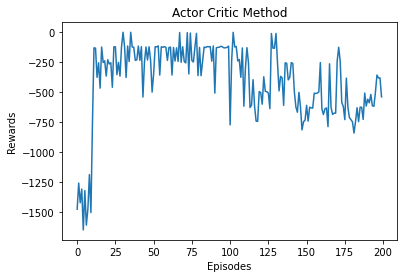

In [ ]:
plt.plot(actor_critic_agent.total_rewards)
plt.title("Actor Critic Method")
plt.xlabel("Episodes")
plt.ylabel("Rewards")
plt.show()

From the above plot we observe that the actor-critic agent performs quite well in the continuous enviroment. It is able to learn the optimal policy contrasting the previous agents which were unable to do so. 

## **Guassian Policy Agent**

A Gaussian policy agent uses a gaussian distribution to predict the action. We use the following Gaussian log likelihood function as loss function:-<br/>
<center>
$L(s, a, r) = -\log(\frac{1}{\sigma\sqrt{2\pi}}e^{-\frac{1}{2}(\frac{a-\mu}{\sigma})^2})r$ </center>

In [34]:
class GaussianAgent:
  def __init__(self, env):

    self.env=env
    self.state_shape=env.observation_space.shape
    self.action_shape=env.action_space.shape[0]
    self.gamma=0.99 
    self.alpha=1e-4 
    self.learning_rate=1e-3
    self.epsilon = 0.1
    self.model=self.create_model() 
    
    self.states=[]
    self.actions=[] 
    self.rewards=[]
    self.total_rewards=[]
    self.optimizer = tf.keras.optimizers.Adam(self.learning_rate)
  
  def create_model(self):
    model=Sequential()
    model.add(layers.Dense(256, input_shape=self.state_shape, activation="relu"))
    model.add(layers.Dense(256, activation="relu"))
    model.add(layers.Dense(2, activation="relu")) 
        
    return model
  
  def set_parametes(self, state, action, reward):

    self.actions.append(action)
    self.states.append(state)
    self.rewards.append(reward)

  def get_action(self, state):

    state=state.reshape([1, state.shape[0]])
    out = self.model.predict(state)
    mu = out[:,0]; sigma = out[:,1]
    # possible_action = 4*tf.exp(-0.5*((np.random.random()-mu)/sigma)**2) - 2
    possible_action = np.random.normal(0, 1, len(mu))
    possible_action = sigma*possible_action + mu
    # print(possible_action)
    legal_action = np.clip(possible_action, -2.0, 2.0)
    return [np.squeeze(legal_action)]

  def get_discounted_rewards(self, rewards): 
    
    discounted_rewards=[]
    cumulative_total_return=0
    for reward in rewards[::-1]:      
      cumulative_total_return=(cumulative_total_return*self.gamma)+reward
      cumulative_total_return*=(1-self.epsilon)
      discounted_rewards.insert(0, cumulative_total_return)

    return np.array(discounted_rewards)

  def custom_loss_gaussian(self, state, action, reward):
    
    out = self.model(state)
    mu = out[:,0]; sigma = out[:,1]
    pdf_value = tf.exp(-0.5 *((action - mu) / (sigma + 1e-5))**2)* 1 / (sigma * tf.sqrt(2 * np.pi) + 1e-5)

    log_probability = tf.math.log(pdf_value + 1e-5)
    loss = - reward * log_probability

    return loss

  def update_policy(self):

    states = np.reshape(self.states, (len(self.states), len(self.states[0])))
    actions = np.reshape(self.actions, (len(self.actions), len(self.actions[0])))
    rewards=np.reshape(self.rewards, (len(self.rewards), 1))

    discounted_rewards=self.get_discounted_rewards(rewards)
    # self.policy_var.append(np.var(discounted_rewards))
  
    with tf.GradientTape() as tape:
      loss_value = self.custom_loss_gaussian(states, actions, discounted_rewards)
      grads = tape.gradient(loss_value, self.model.trainable_variables)

      self.optimizer.apply_gradients(zip(grads, self.model.trainable_variables))
    
    self.states, self.actions, self.rewards=[], [], []


  def train(self, episodes, render_n=50):
    
    env=self.env
    total_rewards=np.zeros(episodes)

    for episode in range(episodes):
      state=env.reset()
      done=False          
      episode_reward=0 
      
      while not done:
        action=self.get_action(state)
        next_state, reward, done, _=env.step(action)
        self.set_parametes(state, action, reward)
        state=next_state
        episode_reward+=reward

        if done:
            self.update_policy()

      total_rewards[episode]=episode_reward
      if episode%5 == 0:
        print("For i:", episode, "Reward =", episode_reward)
    self.total_rewards=total_rewards

  

**Training our agent**

In [35]:
gaussian_agent = GaussianAgent(env)
gaussian_agent.train(400)

For i: 0 Reward = -1164.3178236900737
For i: 5 Reward = -1629.2862011606783
For i: 10 Reward = -863.3872073644155
For i: 15 Reward = -868.5853080810849
For i: 20 Reward = -1145.8756532256557
For i: 25 Reward = -1258.9703524149445
For i: 30 Reward = -863.2086809596781
For i: 35 Reward = -1606.822339047819
For i: 40 Reward = -1875.154730647729
For i: 45 Reward = -1373.420578070161
For i: 50 Reward = -941.3937056852564
For i: 55 Reward = -1489.1365282748552
For i: 60 Reward = -1816.2305698390458
For i: 65 Reward = -1746.6386857194875
For i: 70 Reward = -1626.9151669411867
For i: 75 Reward = -623.9986252178227
For i: 80 Reward = -1508.050712750336
For i: 85 Reward = -1790.7340310131801
For i: 90 Reward = -1874.2374555470674
For i: 95 Reward = -748.3353650406837
For i: 100 Reward = -1168.1251414351552
For i: 105 Reward = -1511.2409520382223
For i: 110 Reward = -1202.9669009148129
For i: 115 Reward = -1242.717905342888
For i: 120 Reward = -1074.5257141012034
For i: 125 Reward = -1110.1657719

**Plotting Results**

The following plot shows rewards obtained in each episode by the agent.

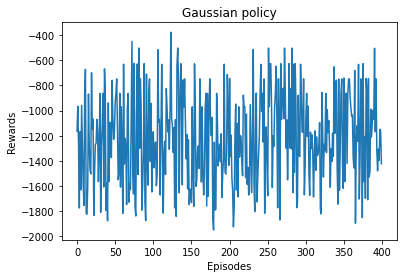

In [36]:
plt.plot(gaussian_agent.total_rewards)
plt.title("Gaussian policy")
plt.xlabel("Episodes")
plt.ylabel("Rewards")
plt.show()

## **Bonus Task**

The bonus task requires us to use suprevised learning approach to train the agent. The pendulum enviroment continuous and generates continuos rewards. So, it is difficult to generate label for actions(action-reward pairs) as required in supervised learning.<br>
We use a gaussian policy for sampling from continuous space. The important idea while training is to use normalised discounted reward over an entire episode that would help in differentiating between "good" and "bad" actions taken in a particular state. A "restless" agent in pendulum enviroment would imply only some of the angles as action are chosen.  

In [37]:
class NormalizedAgent:
  def __init__(self, env):

    self.env=env
    self.state_shape=env.observation_space.shape
    self.action_shape=env.action_space.shape[0]
    self.gamma=0.99 
    self.alpha=1e-4 
    self.learning_rate=1e-4
    self.epsilon = 0.1
    self.model=self.create_model() 
    
    self.states=[]
    self.actions=[] 
    self.rewards=[]
    self.total_rewards=[]
    self.optimizer = tf.keras.optimizers.Adam(self.learning_rate)
  
  def create_model(self):
    model=Sequential()
    model.add(layers.Dense(256, input_shape=self.state_shape, activation="relu"))
    model.add(layers.Dense(256, activation="relu"))
    # model.add(layers.Dense(256, activation="relu"))
    # model.add(layers.Dense(256, activation="relu"))
    model.add(layers.Dense(2, activation="relu")) 
        
    return model
  
  def set_parametes(self, state, action, reward):

    self.actions.append(action)
    self.states.append(state)
    self.rewards.append(reward)

  def get_action(self, state):

    state=state.reshape([1, state.shape[0]])
    out = self.model.predict(state)
    mu = out[:,0]; sigma = out[:,1]
    # possible_action = 4*tf.exp(-0.5*((np.random.random()-mu)/sigma)**2) - 2
    possible_action = np.random.normal(0, 1, len(mu))
    possible_action = sigma*possible_action + mu
    # print(possible_action)
    legal_action = np.clip(possible_action, -2.0, 2.0)
    return [np.squeeze(legal_action)]

  def get_discounted_rewards(self, rewards): 
    
    discounted_rewards=[]
    cumulative_total_return=0
    for reward in rewards[::-1]:      
      cumulative_total_return=(cumulative_total_return*self.gamma)+reward
      cumulative_total_return*=(1-self.epsilon)
      discounted_rewards.insert(0, cumulative_total_return)

    mean_rewards=np.mean(discounted_rewards)
    std_rewards=np.std(discounted_rewards)
    norm_discounted_rewards=(discounted_rewards-
                          mean_rewards)/(std_rewards+1e-5)
    
    return norm_discounted_rewards

  def custom_loss_gaussian(self, state, action, reward):
    
    out = self.model(state)
    mu = out[:,0]; sigma = out[:,1]
    pdf_value = tf.exp(-0.5 *((action - mu) / (sigma + 1e-5))**2)* 1 / (sigma * tf.sqrt(2 * np.pi) + 1e-5)

    log_probability = tf.math.log(pdf_value + 1e-5)
    loss = - reward * log_probability

    return loss

  def update_policy(self):

    states = np.reshape(self.states, (len(self.states), len(self.states[0])))
    actions = np.reshape(self.actions, (len(self.actions), len(self.actions[0])))
    rewards=np.reshape(self.rewards, (len(self.rewards), 1))

    discounted_rewards=self.get_discounted_rewards(rewards)
    # self.policy_var.append(np.var(discounted_rewards))
  
    with tf.GradientTape() as tape:
      loss_value = self.custom_loss_gaussian(states, actions, discounted_rewards)
      grads = tape.gradient(loss_value, self.model.trainable_variables)

      self.optimizer.apply_gradients(zip(grads, self.model.trainable_variables))
    
    self.states, self.actions, self.rewards=[], [], []


  def train(self, episodes, render_n=50):
    
    env=self.env
    total_rewards=np.zeros(episodes)

    for episode in range(episodes):
      state=env.reset()
      done=False          
      episode_reward=0 
      
      while not done:
        action=self.get_action(state)
        next_state, reward, done, _=env.step(action)
        self.set_parametes(state, action, reward)
        state=next_state
        episode_reward+=reward

        if done:
            self.update_policy()

      total_rewards[episode]=episode_reward
      if episode%5 == 0:
        print("For i:", episode, "Reward =", episode_reward)
    self.total_rewards=total_rewards

  

**Training our agent**

In [38]:
normalized_agent = NormalizedAgent(env)
normalized_agent.train(400)

For i: 0 Reward = -968.3544494458877
For i: 5 Reward = -1166.5966086044773
For i: 10 Reward = -1420.2307719281127
For i: 15 Reward = -1490.8926240312185
For i: 20 Reward = -862.7517791360104
For i: 25 Reward = -1780.9668523724451
For i: 30 Reward = -949.641118628184
For i: 35 Reward = -861.476587950877
For i: 40 Reward = -935.653790424815
For i: 45 Reward = -1050.1999310518672
For i: 50 Reward = -1644.2771630042923
For i: 55 Reward = -1179.0687546877584
For i: 60 Reward = -1579.876751155725
For i: 65 Reward = -1280.1003518262567
For i: 70 Reward = -1193.4978184999932
For i: 75 Reward = -1139.84747703211
For i: 80 Reward = -1122.1079710354725
For i: 85 Reward = -1189.1075759454316
For i: 90 Reward = -958.7861617360505
For i: 95 Reward = -1098.0116024695053
For i: 100 Reward = -1174.8256792814454
For i: 105 Reward = -1697.8545560129617
For i: 110 Reward = -1174.8222130304262
For i: 115 Reward = -1784.2761119238874
For i: 120 Reward = -995.3361404229623
For i: 125 Reward = -1023.377757257

**Plotting Results**

The following plot shows rewards obtained in each episode by the agent.

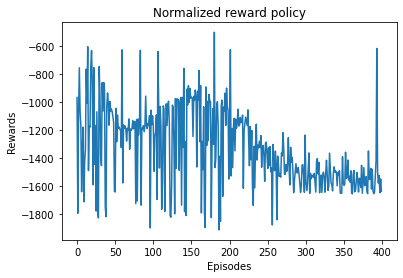

In [39]:
plt.plot(normalized_agent.total_rewards)
plt.title("Normalized reward policy")
plt.xlabel("Episodes")
plt.ylabel("Rewards")
plt.show()